## Xception Model Implementation


Taken from first part of: https://github.com/krishnaik06/Audio-Classification/blob/main/Part%202-%20Audio%20Classification%20Data%20Preprocessing%20And%20Model%20Creation.ipynb


and

https://github.com/hasithsura/Environmental-Sound-Classification/blob/master/ESC50-Pytorch.ipynb

Xception Model from:
https://github.com/tstandley/Xception-PyTorch/blob/master/xception.py

Regularisation from: https://androidkt.com/how-to-add-l1-l2-regularization-in-pytorch-loss-function/

### Setup

In [4]:
# Import Libraries
import os
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook as tqdm
import random
import torchaudio
import torchaudio.transforms as transforms
import math

print('success')

success


In [5]:
# Mount GDRIVE, comment this if not using Gdrive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# comment this if no need to change directory
%cd "/content/drive/MyDrive/Project/"

[Errno 2] No such file or directory: '/content/drive/MyDrive/Project/'
/content


In [7]:
# comment this if not need to copy dataset over
# # Copy dataset over
# !cp -a "/content/drive/MyDrive/DL Project/archive.zip" "/content/"
# !unzip archive.zip
# !rm -rf archive.zip
# !rm -rf sample_data/

In [3]:
# comment this if not need to copy dataset over
# Copy dataset over
!cp -a "/content/drive/MyDrive/Colab Notebooks/50.039 Deep Learning/Project/." "/content/"

cp: cannot open '/content/drive/MyDrive/Colab Notebooks/50.039 Deep Learning/Project/./Project Report.gdoc' for reading: Operation not supported


### Data Preprocessing

In [8]:
angry_path = './angry/'
disgusting_path = './disgusting/'
fear_path = './fear/'
happy_path = './happy/'
neutral_path = './neutral/'
sad_path = './sad/'

# Getting files into a list
from os import listdir
from os.path import isfile, join
angryfiles = [f for f in listdir(angry_path) if f.endswith('.wav')]
disgustingfiles = [f for f in listdir(disgusting_path) if f.endswith('.wav')]
fearfiles = [f for f in listdir(fear_path) if f.endswith('.wav')]
happyfiles = [f for f in listdir(happy_path) if f.endswith('.wav')]
neutralfiles = [f for f in listdir(neutral_path) if f.endswith('.wav')]
sadfiles = [f for f in listdir(sad_path) if f.endswith('.wav')]

# classfiles = [angryfiles, disgustingfiles, fearfiles, happyfiles, neutralfiles, sadfiles]

# for classfile in classfiles:
#     for f in classfile:
#         if  f.endswith('.wav'):
#             continue
#         else:
#             print(f)

print(len(angryfiles),len(sadfiles),len(disgustingfiles),len(neutralfiles),len(fearfiles),len(happyfiles))

1087 1087 1087 1087 1087 1087


In [9]:
data = []
all_files = [angryfiles,sadfiles,disgustingfiles,neutralfiles,fearfiles,happyfiles]
all_paths = ['angry','sad','disgusting','neutral','fear','happy']
all_directories = [angry_path,sad_path,disgusting_path,neutral_path,fear_path,happy_path]

for i in range(len(all_files)):
    for j in range(len(all_files[i])):
        data.append([all_files[i][j],all_paths[i]])

data = pd.DataFrame(data,columns=['name','class'])
print(data)

                     name  class
0     1032_IEO_ANG_MD.wav  angry
1     1012_TIE_ANG_XX.wav  angry
2     1042_ITH_ANG_XX.wav  angry
3     1013_MTI_ANG_XX.wav  angry
4     1052_IOM_ANG_XX.wav  angry
...                   ...    ...
6517  1034_IOM_HAP_XX.wav  happy
6518  1004_DFA_HAP_XX.wav  happy
6519  1047_MTI_HAP_XX.wav  happy
6520  1076_TAI_HAP_XX.wav  happy
6521  1025_ITS_HAP_XX.wav  happy

[6522 rows x 2 columns]


In [10]:
from sklearn.model_selection import train_test_split

# 80-20 Train/Test Split
train, valid = train_test_split(data, test_size=0.2,shuffle = True)

### Data Visualisation

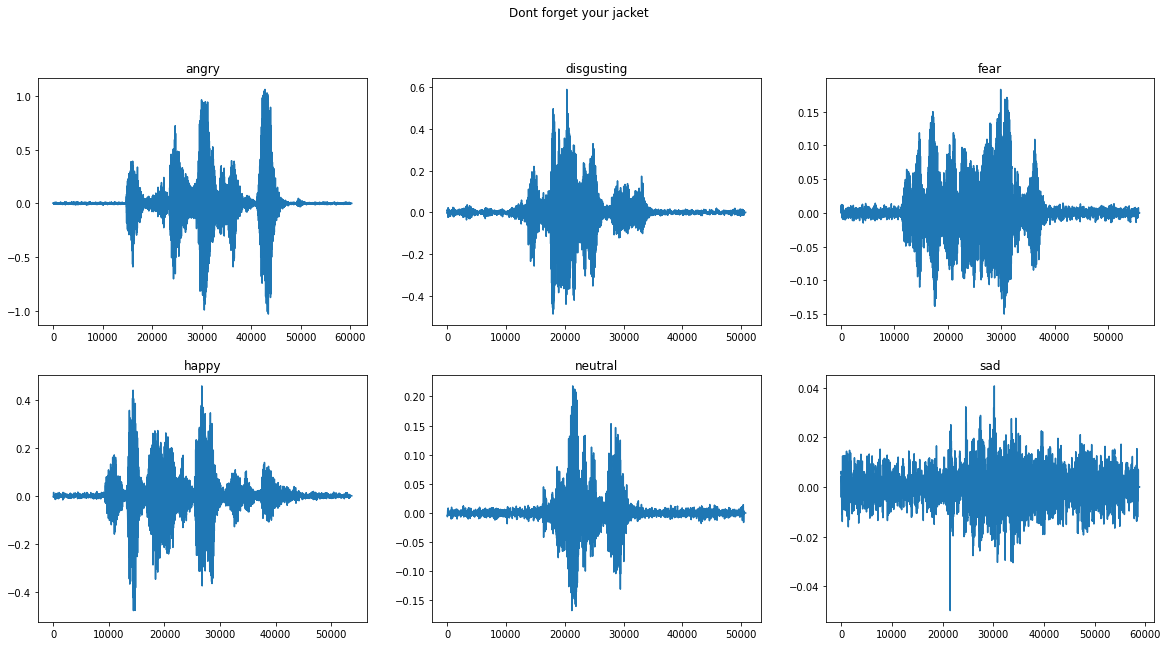

In [11]:
angry_one = angry_path + angryfiles[0]
angry_audio_data,angry_sample_rate=librosa.load(angry_one)
disgusting_one = disgusting_path + disgustingfiles[0]
disgusting_audio_data,disgusting_sample_rate=librosa.load(disgusting_one)
fear_one = fear_path + fearfiles[0]
fear_audio_data,fear_sample_rate=librosa.load(fear_one)
happy_one = happy_path + happyfiles[0]
happy_audio_data,happy_sample_rate=librosa.load(happy_one)
neutral_one = neutral_path + neutralfiles[0]
neutral_audio_data,neutral_sample_rate=librosa.load(neutral_one)
sad_one = sad_path + sadfiles[0]
sad_audio_data,sad_sample_rate=librosa.load(sad_one)

plt.rcParams["figure.figsize"] = (20,10)
fig, ((ax1, ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2, 3)
fig.suptitle('Dont forget your jacket')

ax1.plot(angry_audio_data)
ax1.title.set_text('angry')
ax2.plot(disgusting_audio_data)
ax2.title.set_text('disgusting')
ax3.plot(fear_audio_data)
ax3.title.set_text('fear')
ax4.plot(happy_audio_data)
ax4.title.set_text('happy')
ax5.plot(neutral_audio_data)
ax5.title.set_text('neutral')
ax6.plot(sad_audio_data)
ax6.title.set_text('sad')

### Audio Augmentation 

In [12]:
# time shift
def time_shift(aud, shift_limit):
  sig_len = aud.shape[0]
  shift_amt = int(random.random() * shift_limit * sig_len)
  return torch.from_numpy(np.roll(aud,shift_amt))

# noising
def noising(data, noise_factor):
    noise = np.random.randn(len(data))
    augmented_data = data + noise_factor * noise
    # Cast back to same data type
    return augmented_data

# pitch manipulation
def pitch_manipulate(data,sr, pitch_factor):
  data = torch.flatten(data)
  return torch.Tensor(librosa.effects.pitch_shift(np.array(data), sr, pitch_factor))

# speed manipulation
def speed_manipulate(data, speed_factor):
  data = torch.flatten(data)
  return torch.Tensor(librosa.effects.time_stretch(np.array(data), speed_factor))

#### Time shift 

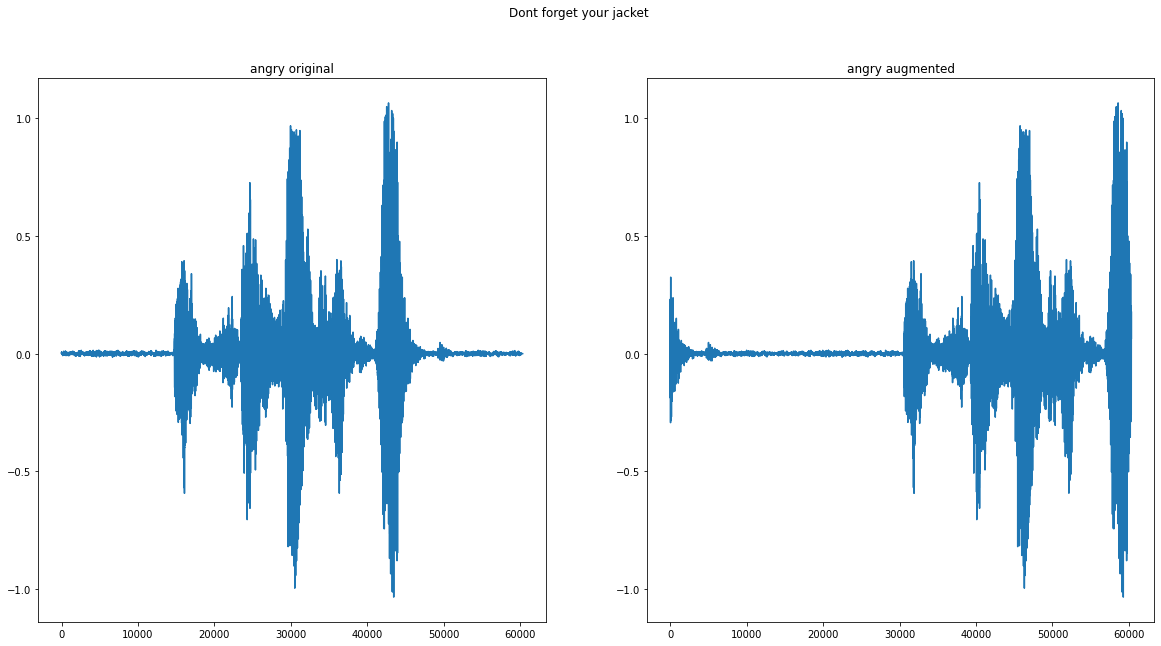

In [13]:
angry_one = angry_path + angryfiles[0]
angry_audio_data,angry_sample_rate = librosa.load(angry_one) # Original data
angry_audio_data_augment = time_shift(angry_audio_data,100) # Augmented data 


plt.rcParams["figure.figsize"] = (20,10)
fig, (ax1,ax2) = plt.subplots(1, 2)
fig.suptitle('Dont forget your jacket')

ax1.plot(angry_audio_data)
ax1.title.set_text('angry original')

ax2.plot(angry_audio_data_augment)
ax2.title.set_text('angry augmented')

#### Noising

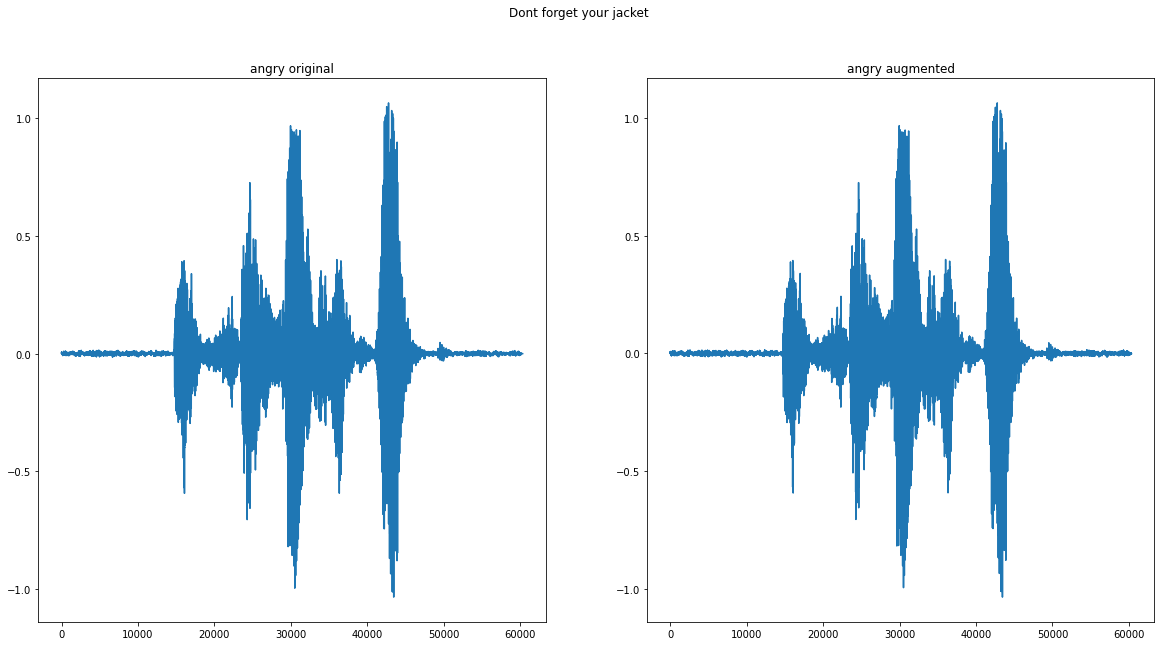

In [14]:
angry_one = angry_path + angryfiles[0]
angry_audio_data,angry_sample_rate = librosa.load(angry_one) # Original data
angry_audio_data_augment = noising(angry_audio_data,0.001) # Augmented data 


plt.rcParams["figure.figsize"] = (20,10)
fig, (ax1,ax2) = plt.subplots(1, 2)
fig.suptitle('Dont forget your jacket')

ax1.plot(angry_audio_data)
ax1.title.set_text('angry original')

ax2.plot(angry_audio_data_augment)
ax2.title.set_text('angry augmented')

#### Pitch Manipulation


In [15]:
%ls

 11oclock.wav
 angry/
'Copy of vanilla_cnn_v2_riley_L2Loss_60%.ipynb'
 disgusting/
 drive/
 EDA.ipynb
 fear/
 flagged/
 happy/
 mfccs.csv
 model.pth
 music/
 neutral/
'Project dataset'/
 sad/
 sample_data/
 vanilla_cnn1d_v1_riley.ipynb
 vanilla_cnn_v1_riley.ipynb
 vanilla_cnn_v2_riley_60per.ipynb
 vanilla_cnn_v2_riley.ipynb
 vanilla_cnn_v2_riley_L2Loss_55%.ipynb
 vanilla_cnn_v2_riley_L2Loss_58%.ipynb
 vanilla_cnn_v2_riley_L2Loss_60%.ipynb
 vanilla_cnn_v3_riley.ipynb
 vanilla_cnn_v4_riley.ipynb
 vanilla_rnn1d_v1_riley.ipynb
 Xception_hy_riley.ipynb
 Xception.ipynb


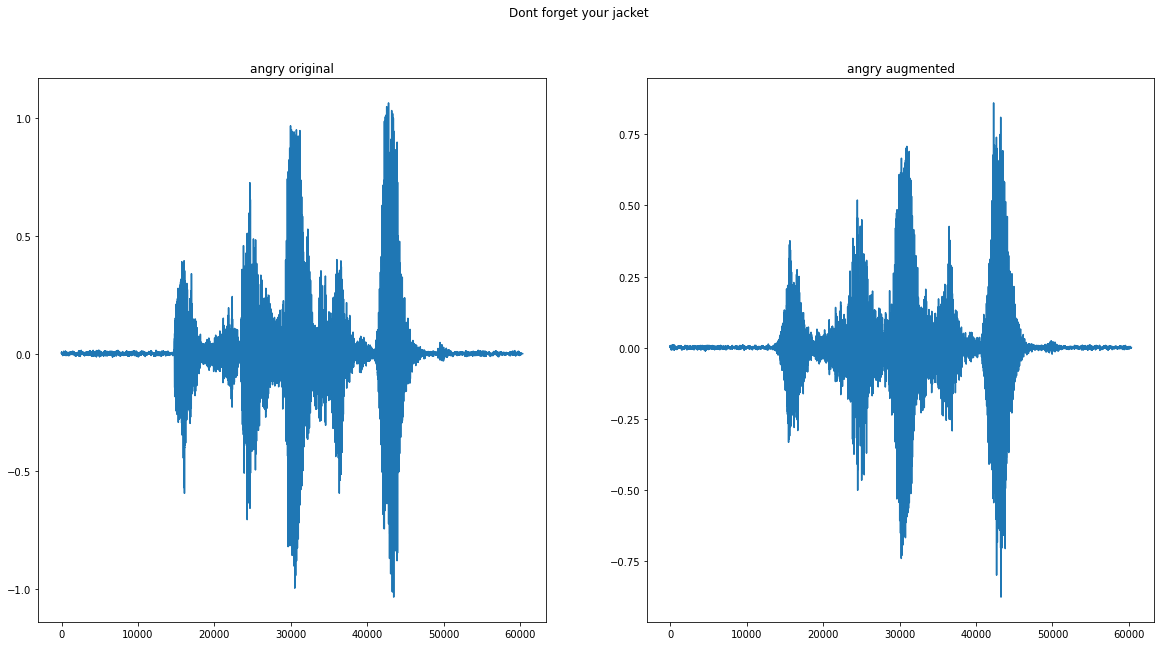

In [16]:
angry_one = angry_path + angryfiles[0]
angry_audio_data,angry_sample_rate = librosa.load(angry_one) # Original data
angry_audio_data_tensor = torch.Tensor(angry_audio_data[np.newaxis,...])

angry_audio_data_augment = pitch_manipulate(angry_audio_data_tensor,angry_sample_rate,2) # Augmented data 
angry_audio_data_augment = angry_audio_data_augment.numpy()

plt.rcParams["figure.figsize"] = (20,10)
fig, (ax1,ax2) = plt.subplots(1, 2)
fig.suptitle('Dont forget your jacket')

ax1.plot(angry_audio_data)
ax1.title.set_text('angry original')

ax2.plot(angry_audio_data_augment)
ax2.title.set_text('angry augmented')

#### Speed Manipulation

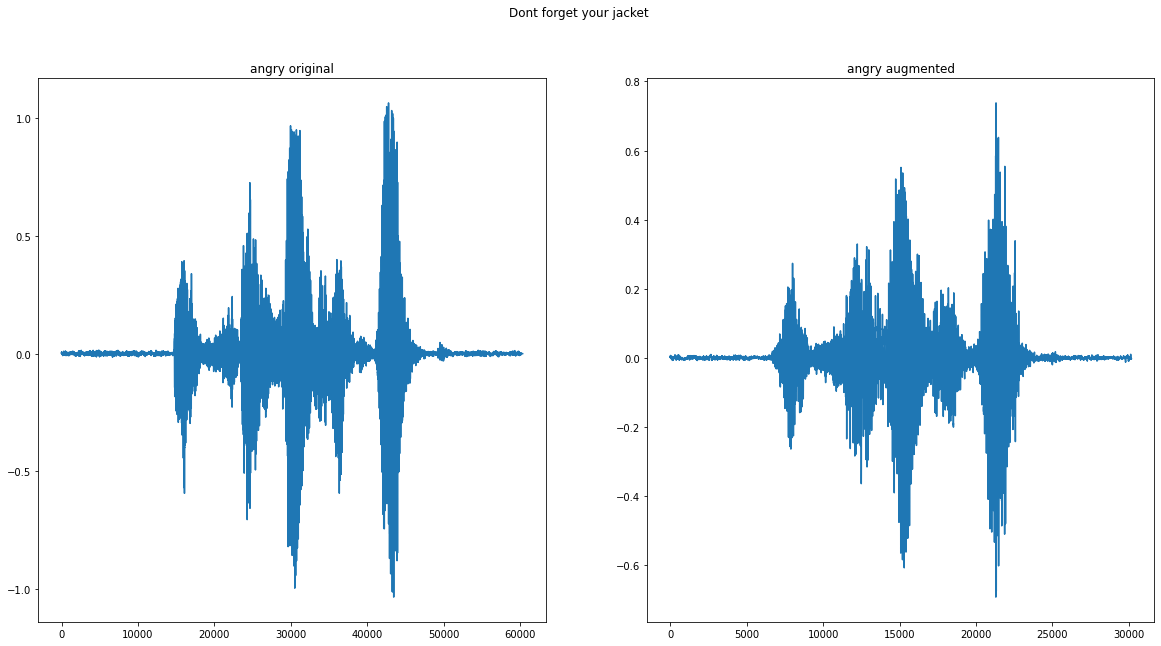

In [17]:
angry_one = angry_path + angryfiles[0]
angry_audio_data,angry_sample_rate = librosa.load(angry_one) # Original data
angry_audio_data_tensor = torch.Tensor(angry_audio_data[np.newaxis,...])

angry_audio_data_augment = speed_manipulate(angry_audio_data_tensor,2) # Augmented data 
angry_audio_data_augment = angry_audio_data_augment.numpy()

plt.rcParams["figure.figsize"] = (20,10)
fig, (ax1,ax2) = plt.subplots(1, 2)
fig.suptitle('Dont forget your jacket')

ax1.plot(angry_audio_data)
ax1.title.set_text('angry original')

ax2.plot(angry_audio_data_augment)
ax2.title.set_text('angry augmented')

### Spectrogram Augmentation

In [18]:
def freq_mask(spec, F=188, num_masks=1):
    test = spec.clone()
    num_mel_channels = test.shape[2]
    for i in range(0, num_masks):        
        freq = random.randrange(1,10)
        zero = random.randrange(0, F - num_mel_channels)
        # avoids randrange error if values are equal and range is empty
        if (zero == zero + freq): return test
        mask_end = random.randrange(zero, zero + freq) 
        test[0][zero:mask_end] = test.mean()
    return test

def time_mask(spec, time=128, num_masks=1):
    test = spec.clone()
    length = test.shape[1]
    for i in range(0, num_masks):
        t = random.randrange(1,4)
        zero = random.randrange(0, length-time)
        if (zero == zero + t): return test
        mask_end = random.randrange(zero, zero + t)
        test[0][:,zero:mask_end] = test.mean()
    return test

### Define a Torchaudio Spectrogram to Image

In [19]:
# Torch audio tensor to image
def tensor_to_img(spectrogram): 
    plt.imshow(spectrogram[0],aspect='auto', origin='lower')
    plt.show();
    display(spectrogram.shape)
    
def tfm_spectro(ad, sr=16000, to_db_scale=False, n_fft=1024, 
                ws=None, hop=None, f_min=0.0, f_max=-80, pad=0, n_mels=128):
    # We must reshape signal for torchaudio to generate the spectrogram.

    data = ad[0]
    data = pad_trunc(data,sr,3000)

    # data = noising(data,100) # apply noising data augmentation, try noising the f out of this and see if the model can still learn
    # data = time_shift(data,2) # apply timeshift data augmentation
    # data = pitch_manipulate(data,sr,2) # apply pitch data augmentation
    # data = speed_manipulate(data,1.25) # apply speed data augmentation
    
    # cast dtype of tensor back to float32
    data = data.float()

    mel = transforms.MelSpectrogram(sample_rate=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop, 
                                    f_min=f_min, f_max=f_max, pad=pad,)(data.reshape(1, -1))
    mel = mel.permute(0,2,1) # swap dimension, mostly to look sane to a human.
    if to_db_scale: mel = transforms.AmplitudeToDB(stype='magnitude', top_db=f_max)(mel)
    return mel

def pad_trunc(ad, sr, max_ms):
  sig_len = ad.shape[1]
  max_len = sr//1000 * max_ms # max len should always be 16000//1000 * 3000

  if (sig_len > max_len):
    # Truncate the signal to the given length
    ad = ad[:,:max_len]

      # process back to numpy array to be fed as input.

  elif (sig_len < max_len):
    # Length of padding to add at the beginning and end of the signal
    pad_begin_len = random.randint(0, max_len - sig_len)
    pad_end_len = max_len - sig_len - pad_begin_len

    # Pad with 0s
    pad_begin = torch.zeros((1, pad_begin_len))
    pad_end = torch.zeros((1, pad_end_len))

    # print(pad_begin.shape,ad.shape,pad_end.shape)
    ad = torch.cat((pad_begin, ad, pad_end), 1)
      
  return ad

### Visualization of Spectrograms

/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:595: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  "At least one mel filterbank has all zero values. "


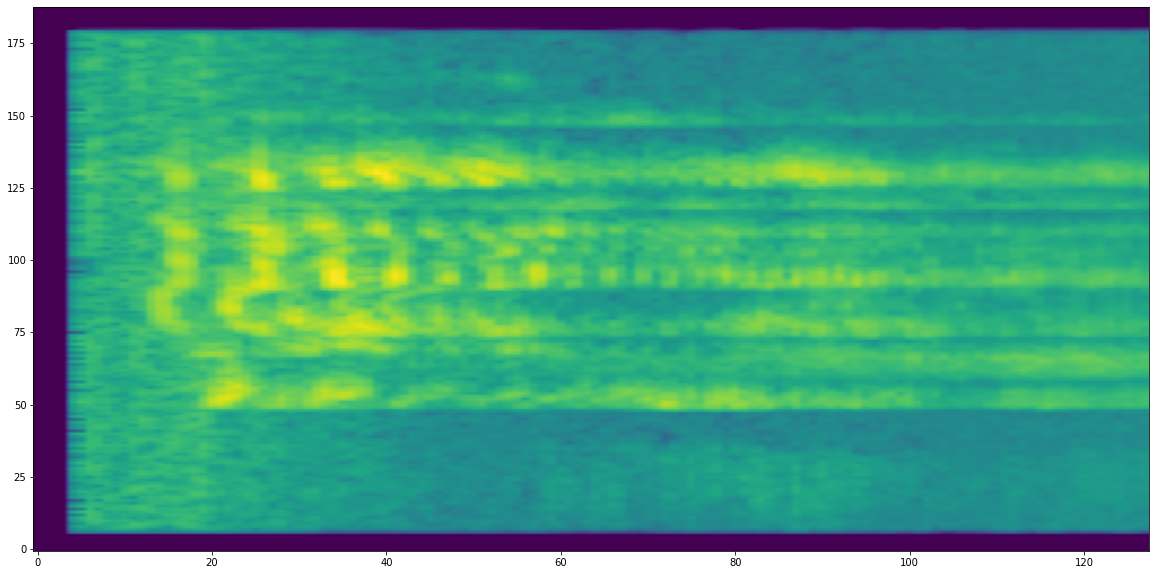

torch.Size([1, 188, 128])

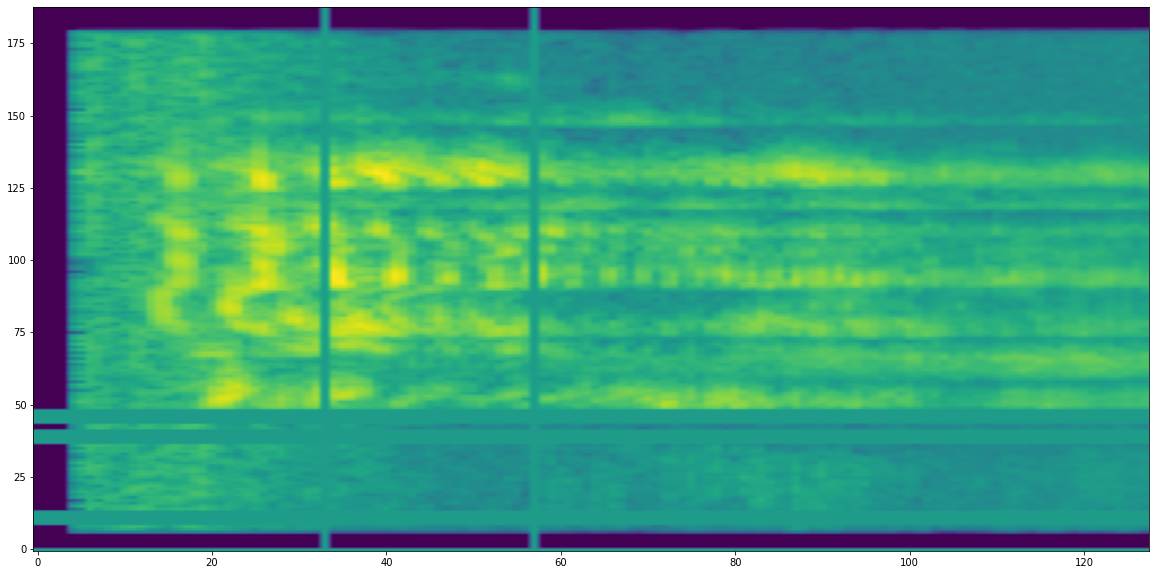

torch.Size([1, 188, 128])

In [20]:
angry = torchaudio.load(angry_one)
angry = tfm_spectro(angry, ws=512, hop=256, n_mels=128, to_db_scale=True, f_max=8000, f_min=-80) # returns a spectrogram
tensor_to_img(angry) 
angry = freq_mask(angry,num_masks=5)
angry = time_mask(angry,num_masks=5)
tensor_to_img(angry)

/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:595: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  "At least one mel filterbank has all zero values. "


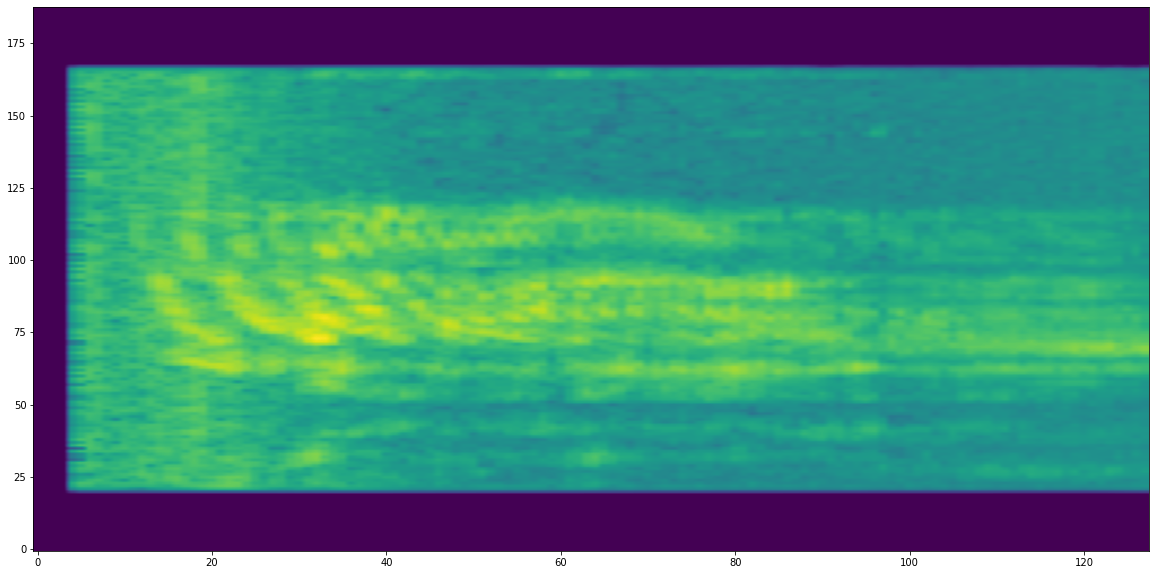

torch.Size([1, 188, 128])

In [21]:
disgusting = torchaudio.load(disgusting_one)
disgusting = tfm_spectro(disgusting, ws=512, hop=256, n_mels=128, to_db_scale=True, f_max=8000, f_min=-80)
tensor_to_img(disgusting)

/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:595: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  "At least one mel filterbank has all zero values. "


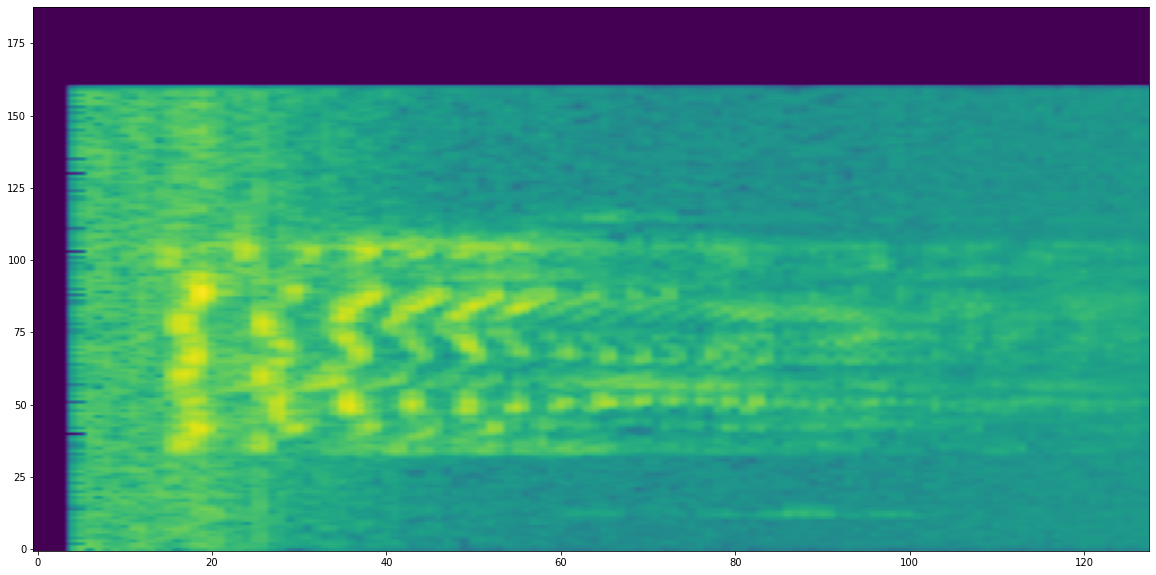

torch.Size([1, 188, 128])

In [22]:
fear = torchaudio.load(fear_one)
fear = tfm_spectro(fear, ws=512, hop=256, n_mels=128, to_db_scale=True, f_max=8000, f_min=-80)
tensor_to_img(fear)

/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:595: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  "At least one mel filterbank has all zero values. "


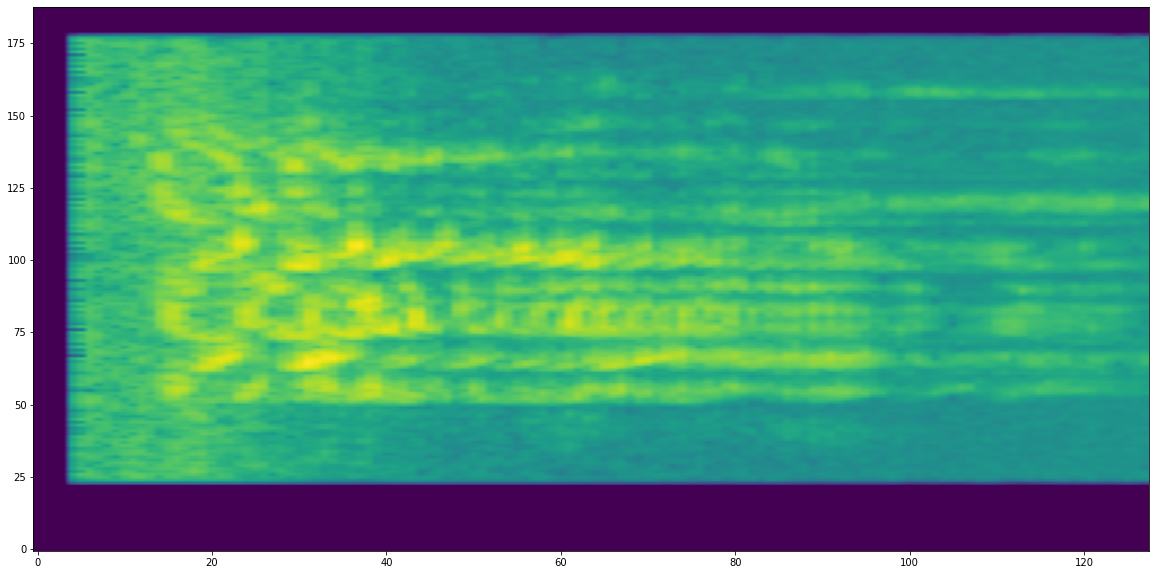

torch.Size([1, 188, 128])

In [23]:
happy = torchaudio.load(happy_one)
happy = tfm_spectro(happy, ws=512, hop=256, n_mels=128, to_db_scale=True, f_max=8000, f_min=-80)
tensor_to_img(happy)

/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:595: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  "At least one mel filterbank has all zero values. "


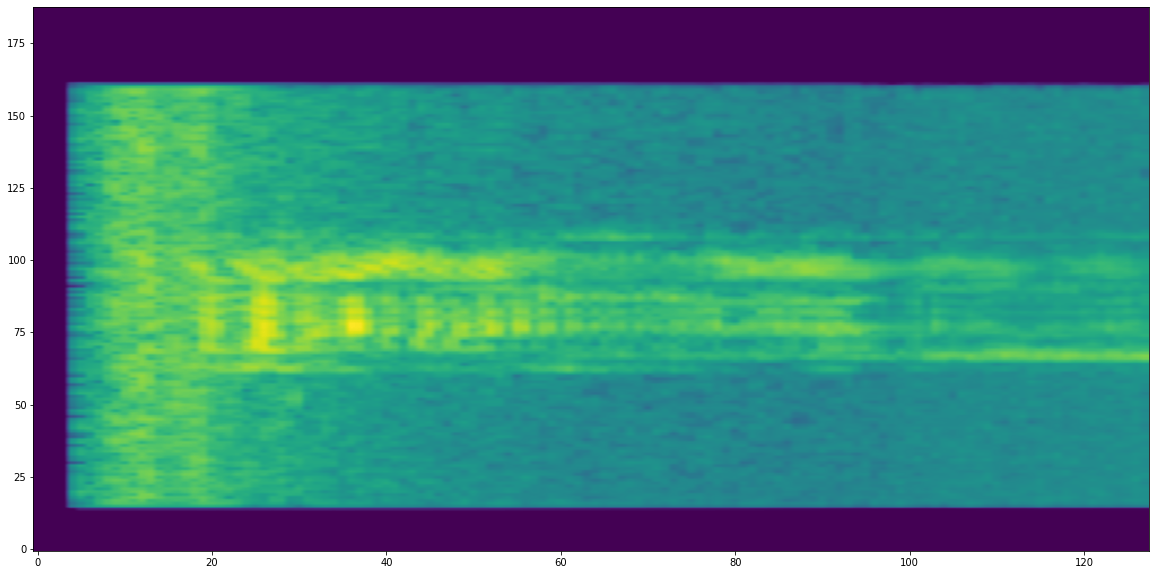

torch.Size([1, 188, 128])

In [24]:
neutral = torchaudio.load(neutral_one)
neutral = tfm_spectro(neutral, ws=512, hop=256, n_mels=128, to_db_scale=True, f_max=8000, f_min=-80)
tensor_to_img(neutral)

/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:595: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  "At least one mel filterbank has all zero values. "


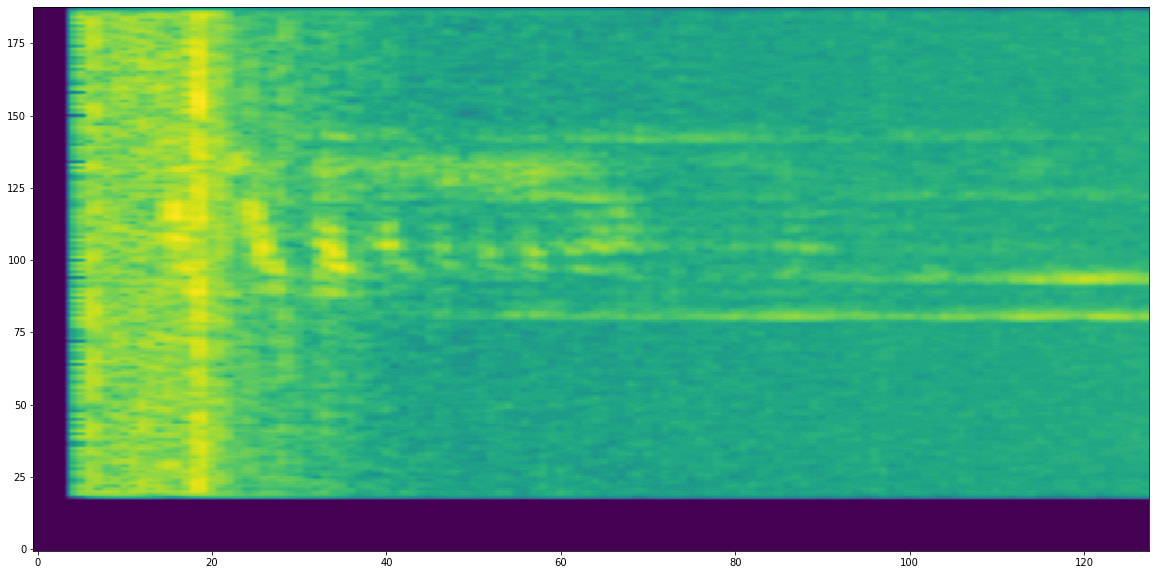

torch.Size([1, 188, 128])

In [25]:
sad = torchaudio.load(sad_one)
sad = tfm_spectro(sad, ws=512, hop=256, n_mels=128, to_db_scale=True, f_max=8000, f_min=-80)
tensor_to_img(sad)

### Create Data Loaders

In [26]:
class AudioData(Dataset):
  def __init__(self, df):
    self.df = df
    self.data = []
    self.labels = []
    self.c2i={}
    self.i2c={}
    self.categories = sorted(['angry','sad','disgusting','neutral','fear','happy'])
    for i, category in enumerate(self.categories):
      self.c2i[category]=i
      self.i2c[i]=category
    for ind in tqdm(range(len(df))):
      row = df.iloc[ind]
      file_path = './' + row['class'] + '/' + row['name']


      # LOADING DATA HERE, apply data augmentation here if needed
      data = torchaudio.load(file_path) 
      spectro = tfm_spectro(data, ws=512, hop=256, n_mels=128, to_db_scale=True, f_max=8000, f_min=-80)
      # spectro = freq_mask(spectro,num_masks=20) # frequency data augmentation
      # spectro = time_mask(spectro,num_masks=20) # time data augmentation
      self.data.append(spectro)

      self.labels.append(self.c2i[row['class']])
  def __len__(self):
    return len(self.data)
  def __getitem__(self, idx):
    return self.data[idx], self.labels[idx]

In [27]:
train_data = AudioData(train)
valid_data = AudioData(valid)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


  0%|          | 0/5217 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:595: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  "At least one mel filterbank has all zero values. "


  0%|          | 0/1305 [00:00<?, ?it/s]

In [28]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=16, shuffle=True)

### Setup Torch for Training 

In [29]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
 # device = torch.device('cpu')
print(device)

seed = 0
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

cuda:0


In [30]:
torch.cuda.device_count()
torch.cuda.get_device_name()

'Tesla T4'

### Create the model

In [31]:
# Separable Convolution Layer
class SeparableConv2d(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size=1,stride=1,padding=0,dilation=1,bias=False):
        super(SeparableConv2d,self).__init__()

        self.conv1 = nn.Conv2d(in_channels,in_channels,kernel_size,stride,padding,dilation,groups=in_channels,bias=bias)
        self.pointwise = nn.Conv2d(in_channels,out_channels,1,1,0,1,1,bias=bias)
    
    def forward(self,x):
        x = self.conv1(x)
        x = self.pointwise(x)
        return x

# Skip Connection
class Block(nn.Module):
    def __init__(self,in_filters,out_filters,reps,strides=1,start_with_relu=True,grow_first=True):
        super(Block, self).__init__()

        if out_filters != in_filters or strides!=1:
            self.skip = nn.Conv2d(in_filters,out_filters,1,stride=strides, bias=False)
            self.skipbn = nn.BatchNorm2d(out_filters)
        else:
            self.skip=None
        
        self.relu = nn.ReLU(inplace=True)

        rep=[]

        filters=in_filters
        if grow_first:
            rep.append(self.relu)
            rep.append(SeparableConv2d(in_filters,out_filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(out_filters))
            filters = out_filters

        for i in range(reps-1):
            rep.append(self.relu)
            rep.append(SeparableConv2d(filters,filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(filters))
        
        if not grow_first:
            rep.append(self.relu)
            rep.append(SeparableConv2d(in_filters,out_filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(out_filters))

        if not start_with_relu:
            rep = rep[1:]
        else:
            rep[0] = nn.ReLU(inplace=False)

        if strides != 1:
            rep.append(nn.MaxPool2d(3,strides,1))
        self.rep = nn.Sequential(*rep)

    def forward(self,inp):
        x = self.rep(inp)

        if self.skip is not None:
            skip = self.skip(inp)
            skip = self.skipbn(skip)
        else:
            skip = inp

        x+=skip
        return x


In [40]:
class Xception(nn.Module):
    def __init__(self, num_classes=6):
        super(Xception, self).__init__()

        self.num_classes = num_classes

        # Entry Flow
        # in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros'
        self.conv1 = nn.Conv2d(1, 32, 3, 2, 0, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)

        ## DROPOUT default is already 0.5 ##
        self.dropout = nn.Dropout()
        ####################################

        self.conv2 = nn.Conv2d(32,64,3,bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        #do relu here

        self.block1=Block(64,128,2,2,start_with_relu=False,grow_first=True)
        self.block2=Block(128,256,2,2,start_with_relu=True,grow_first=True)
        self.block3=Block(256,728,2,2,start_with_relu=True,grow_first=True)

        # Middle Flow
        self.block4=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block5=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block6=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block7=Block(728,728,3,1,start_with_relu=True,grow_first=True)

        self.block8=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block9=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block10=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block11=Block(728,728,3,1,start_with_relu=True,grow_first=True)

        # Exit Flow
        self.block12=Block(728,1024,2,2,start_with_relu=True,grow_first=False)

        self.conv3 = SeparableConv2d(1024,1536,3,1,1)
        self.bn3 = nn.BatchNorm2d(1536)

        #do relu here

        self.conv4 = SeparableConv2d(1536,2048,3,1,1)
        self.bn4 = nn.BatchNorm2d(2048)

        self.fc = nn.Linear(2048, num_classes)


        #------- init weights --------
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        #-----------------------------


    def forward(self, x): # added 4 dropouts
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        # x = self.dropout(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        # x = self.dropout(x)
        
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = self.block7(x)
        x = self.block8(x)
        x = self.block9(x)
        x = self.block10(x)
        x = self.block11(x)
        x = self.block12(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        # x = self.dropout(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [ ]:
model = Xception()
model = model.cuda()

### Set other parameters


1.   Vary different multi class loss functions
2.   Vary optimizer for faster reach of minimum loss



In [ ]:
import torch.optim as optim

# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0) # Set the original weight decay to 0, disable auto weight decay for SGD

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.RMSprop(model.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

train_accu = []
train_losses = []
eval_accu = []
eval_losses = []

In [ ]:
def train(epoch):
  print('\nEpoch : %d'%epoch)
  
  model.train()
  
  running_loss=0
  correct=0
  total=0

  for data in tqdm(train_loader):
    
    inputs,labels=data[0].to(device),data[1].to(device)
    inputs,label=inputs.cuda(),labels.cuda()
    
    outputs=model(inputs.float())

    criterion = nn.CrossEntropyLoss()
    criterion = criterion.cuda()

    loss = criterion(outputs,labels)

    ################ MANUAL REGULARISATION ###################

    #Replace pow(2.0) with abs() for L1 regularization
    l2_lambda = 0.0001
    l2_norm = sum(p.pow(2.0).sum()
                  for p in model.parameters())

    loss = loss + l2_lambda * l2_norm

    ###################################################

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    
    _, predicted = outputs.max(1)

    # print(labels,predicted) # Checking the ground truths
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()
      
  train_loss=running_loss/len(train_loader)
  accu=100.*correct/total
  
  train_accu.append(accu)
  train_losses.append(train_loss)
  print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accu))

In [ ]:
def test(epoch):
  print('\nEpoch : %d'%epoch)
  model.eval()

  running_loss=0
  correct=0
  total=0

  with torch.no_grad():
    for data in tqdm(valid_loader):
      inputs,labels=data[0].to(device),data[1].to(device)
      inputs,label=inputs.cuda(),labels.cuda()
      
      outputs=model(inputs.float())

      criterion = nn.CrossEntropyLoss()
      criterion = criterion.cuda()
      
      loss= criterion(outputs,labels)

      running_loss+=loss.item()
      
      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()
  
  test_loss=running_loss/len(valid_loader)
  accu=100.*correct/total

  eval_losses.append(test_loss)
  eval_accu.append(accu)

  print('Test Loss: %.3f | Accuracy: %.3f'%(test_loss,accu)) 

In [ ]:
epochs=50
patience = 5

count = 0
previous_loss = 100
for epoch in range(1,epochs+1): 
  train(epoch)
  test(epoch)
  print("best test accuracy =",max(eval_accu))

  # Naive implementation of early stop
  if eval_losses[-1]>previous_loss:
    count+=1
    if count>patience:
      del train_losses[-patience:]
      del train_accu[-patience:]
      del eval_losses[-patience:]
      del eval_accu[-patience:]
      break

  else:
    count=0
    PATH = './model.pth'
    torch.save(model, PATH)

  if epoch==epochs:
    PATH = './model.pth'
    torch.save(model, PATH)

  previous_loss = eval_losses[-1]

# Confusion Matrix
y_pred = []
y_true = []
valid_loader2 = DataLoader(valid_data, batch_size=1, shuffle=True)

with torch.no_grad():
  for data in (valid_loader2):
    inputs,labels=data[0].to(device),data[1].to(device)
    classes = sorted(['angry','sad','disgusting','neutral','fear','happy'])
    y_true.append(classes[labels])
    outputs = model(inputs.float())
    _, predicted = outputs.max(1)
    y_pred.append(classes[predicted])

print(y_pred)
print(y_true)

from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_true, y_pred, labels = ['angry','sad','disgusting','neutral','fear','happy']))


Epoch : 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 9.115 | Accuracy: 36.381

Epoch : 1


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.529 | Accuracy: 37.165
best test accuracy = 37.16475095785441

Epoch : 2


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 8.924 | Accuracy: 45.467

Epoch : 2


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.299 | Accuracy: 49.425
best test accuracy = 49.42528735632184

Epoch : 3


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 8.763 | Accuracy: 54.476

Epoch : 3


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.328 | Accuracy: 53.410
best test accuracy = 53.40996168582375

Epoch : 4


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 8.643 | Accuracy: 59.766

Epoch : 4


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.998 | Accuracy: 36.092
best test accuracy = 53.40996168582375

Epoch : 5


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 8.556 | Accuracy: 62.833

Epoch : 5


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.560 | Accuracy: 49.195
best test accuracy = 53.40996168582375

Epoch : 6


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 8.484 | Accuracy: 65.325

Epoch : 6


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.443 | Accuracy: 53.333
best test accuracy = 53.40996168582375

Epoch : 7


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 8.367 | Accuracy: 70.730

Epoch : 7


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.579 | Accuracy: 49.349
best test accuracy = 53.40996168582375

Epoch : 8


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 8.269 | Accuracy: 74.506

Epoch : 8


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 4.532 | Accuracy: 18.238
best test accuracy = 53.40996168582375

Epoch : 9


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 8.217 | Accuracy: 75.887

Epoch : 9


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 2.905 | Accuracy: 26.590
best test accuracy = 53.40996168582375

Epoch : 10


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 8.167 | Accuracy: 77.228

Epoch : 10


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.423 | Accuracy: 53.257
best test accuracy = 53.40996168582375

Epoch : 11


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 8.092 | Accuracy: 80.832

Epoch : 11


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 2.172 | Accuracy: 46.897
best test accuracy = 53.40996168582375

Epoch : 12


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 7.997 | Accuracy: 83.420

Epoch : 12


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 2.606 | Accuracy: 42.912
best test accuracy = 53.40996168582375

Epoch : 13


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 7.966 | Accuracy: 85.413

Epoch : 13


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 2.075 | Accuracy: 49.119
best test accuracy = 53.40996168582375

Epoch : 14


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 7.944 | Accuracy: 85.969

Epoch : 14


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.574 | Accuracy: 58.697
best test accuracy = 58.69731800766284

Epoch : 15


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 7.883 | Accuracy: 87.809

Epoch : 15


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.590 | Accuracy: 51.877
best test accuracy = 58.69731800766284

Epoch : 16


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 7.797 | Accuracy: 91.528

Epoch : 16


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 2.649 | Accuracy: 39.923
best test accuracy = 58.69731800766284

Epoch : 17


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 7.782 | Accuracy: 91.528

Epoch : 17


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 3.427 | Accuracy: 45.670
best test accuracy = 58.69731800766284

Epoch : 18


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 7.724 | Accuracy: 93.751

Epoch : 18


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.750 | Accuracy: 57.395
best test accuracy = 58.69731800766284

Epoch : 19


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 7.660 | Accuracy: 96.205

Epoch : 19


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.690 | Accuracy: 58.467
best test accuracy = 58.69731800766284

Epoch : 20


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 7.703 | Accuracy: 94.345

Epoch : 20


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 2.376 | Accuracy: 51.111
best test accuracy = 58.69731800766284

Epoch : 21


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 7.708 | Accuracy: 94.211

Epoch : 21


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.644 | Accuracy: 59.617
best test accuracy = 59.616858237547895

Epoch : 22


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 7.687 | Accuracy: 94.710

Epoch : 22


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 2.768 | Accuracy: 44.904
best test accuracy = 59.616858237547895

Epoch : 23


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 7.648 | Accuracy: 96.147

Epoch : 23


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 2.388 | Accuracy: 51.111
best test accuracy = 59.616858237547895

Epoch : 24


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 7.619 | Accuracy: 97.106

Epoch : 24


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 2.678 | Accuracy: 51.034
best test accuracy = 59.616858237547895

Epoch : 25


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 7.607 | Accuracy: 97.393

Epoch : 25


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.655 | Accuracy: 60.996
best test accuracy = 60.99616858237548

Epoch : 26


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 7.596 | Accuracy: 97.681

Epoch : 26


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.591 | Accuracy: 61.839
best test accuracy = 61.839080459770116

Epoch : 27


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 7.585 | Accuracy: 98.064

Epoch : 27


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 3.561 | Accuracy: 49.195
best test accuracy = 61.839080459770116

Epoch : 28


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 7.565 | Accuracy: 98.831

Epoch : 28


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 3.451 | Accuracy: 44.751
best test accuracy = 61.839080459770116

Epoch : 29


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 7.580 | Accuracy: 98.045

Epoch : 29


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 2.504 | Accuracy: 55.862
best test accuracy = 61.839080459770116

Epoch : 30


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 7.583 | Accuracy: 97.911

Epoch : 30


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 3.219 | Accuracy: 51.494
best test accuracy = 61.839080459770116

Epoch : 31


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 7.574 | Accuracy: 98.102

Epoch : 31


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 3.229 | Accuracy: 51.954
best test accuracy = 61.839080459770116

Epoch : 32


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 7.566 | Accuracy: 98.313

Epoch : 32


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 2.084 | Accuracy: 58.391
best test accuracy = 61.839080459770116

Epoch : 33


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 7.553 | Accuracy: 98.735

Epoch : 33


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.880 | Accuracy: 60.690
best test accuracy = 61.839080459770116

Epoch : 34


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 7.540 | Accuracy: 99.099

Epoch : 34


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 2.601 | Accuracy: 57.165
best test accuracy = 61.839080459770116

Epoch : 35


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 7.522 | Accuracy: 99.712

Epoch : 35


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.825 | Accuracy: 63.065
best test accuracy = 63.065134099616856

Epoch : 36


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 7.512 | Accuracy: 99.847

Epoch : 36


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.806 | Accuracy: 62.222
best test accuracy = 63.065134099616856

Epoch : 37


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 7.507 | Accuracy: 99.942

Epoch : 37


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.865 | Accuracy: 63.142
best test accuracy = 63.14176245210728

Epoch : 38


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 7.501 | Accuracy: 100.000

Epoch : 38


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.775 | Accuracy: 63.372
best test accuracy = 63.371647509578544

Epoch : 39


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 7.498 | Accuracy: 100.000

Epoch : 39


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.731 | Accuracy: 63.831
best test accuracy = 63.83141762452107

Epoch : 40


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 7.496 | Accuracy: 99.981

Epoch : 40


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.773 | Accuracy: 64.291
best test accuracy = 64.2911877394636

Epoch : 41


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 7.493 | Accuracy: 99.981

Epoch : 41


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.787 | Accuracy: 63.525
best test accuracy = 64.2911877394636

Epoch : 42


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 7.490 | Accuracy: 100.000

Epoch : 42


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.889 | Accuracy: 62.835
best test accuracy = 64.2911877394636

Epoch : 43


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 7.488 | Accuracy: 99.962

Epoch : 43


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.874 | Accuracy: 62.299
best test accuracy = 64.2911877394636

Epoch : 44


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 7.486 | Accuracy: 99.962

Epoch : 44


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.988 | Accuracy: 60.766
best test accuracy = 64.2911877394636

Epoch : 45


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 7.486 | Accuracy: 99.923

Epoch : 45


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.876 | Accuracy: 63.218
best test accuracy = 64.2911877394636

Epoch : 46


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 7.481 | Accuracy: 100.000

Epoch : 46


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.782 | Accuracy: 63.448
best test accuracy = 64.2911877394636

Epoch : 47


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 7.478 | Accuracy: 99.981

Epoch : 47


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.852 | Accuracy: 62.835
best test accuracy = 64.2911877394636

Epoch : 48


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 7.475 | Accuracy: 100.000

Epoch : 48


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.785 | Accuracy: 64.981
best test accuracy = 64.98084291187739

Epoch : 49


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 7.472 | Accuracy: 100.000

Epoch : 49


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.803 | Accuracy: 63.295
best test accuracy = 64.98084291187739

Epoch : 50


  0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 7.470 | Accuracy: 99.981

Epoch : 50


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.824 | Accuracy: 62.912
best test accuracy = 64.98084291187739
['sad', 'angry', 'fear', 'sad', 'happy', 'sad', 'disgusting', 'happy', 'sad', 'neutral', 'disgusting', 'sad', 'angry', 'happy', 'happy', 'happy', 'fear', 'happy', 'neutral', 'disgusting', 'sad', 'disgusting', 'sad', 'neutral', 'fear', 'angry', 'happy', 'disgusting', 'angry', 'fear', 'disgusting', 'neutral', 'sad', 'angry', 'disgusting', 'fear', 'disgusting', 'happy', 'happy', 'fear', 'fear', 'neutral', 'neutral', 'sad', 'neutral', 'fear', 'sad', 'angry', 'neutral', 'happy', 'neutral', 'happy', 'disgusting', 'disgusting', 'disgusting', 'angry', 'angry', 'fear', 'neutral', 'neutral', 'disgusting', 'angry', 'disgusting', 'sad', 'neutral', 'angry', 'sad', 'neutral', 'angry', 'angry', 'disgusting', 'happy', 'happy', 'angry', 'sad', 'sad', 'fear', 'sad', 'disgusting', 'happy', 'neutral', 'disgusting', 'fear', 'disgusting', 'fear', 'sad', 'neutral', 'angry', 'happy', 'fear', 'happy', 'happy', 'sad', 'neutral', 'sad', '

### Visualising Model Performance

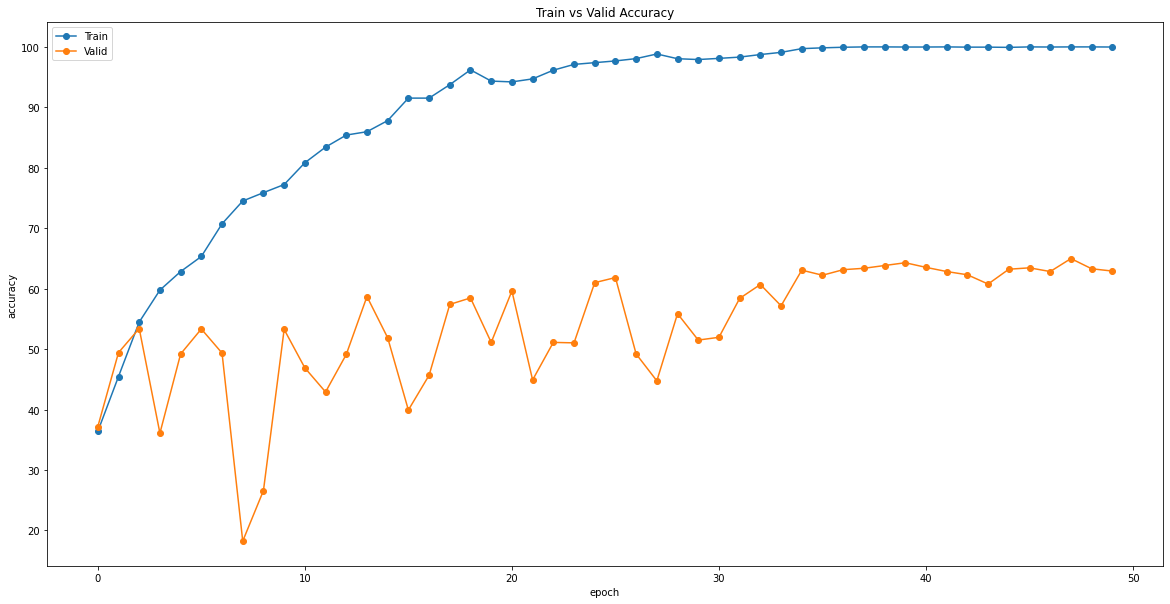

In [ ]:
plt.plot(train_accu,'-o')
plt.plot(eval_accu,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')

plt.show()

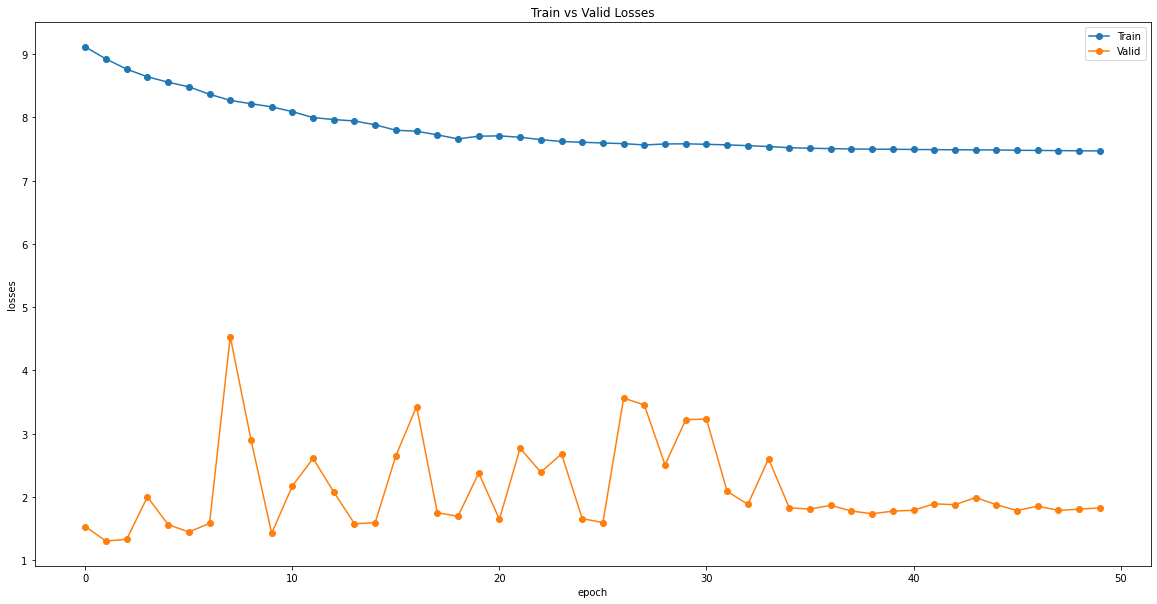

In [ ]:
plt.plot(train_losses,'-o')
plt.plot(eval_losses,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')

plt.show()

In [ ]:
torch.save(model, 'model1.pth')

## Reproducing results for trained model

follow instructions below to recreate the plot of graphs, and confusion matrices from the weights
- Make sure you have all datasets ready, dataloaders previously loaded ande defined
- And the Xception model previously defined
- Run the following code cell with *model.pth* in your directory to produce the confusion matrix

In [41]:
model = torch.load('model.pth')

# Confusion Matrix
y_pred = []
y_true = []
valid_loader2 = DataLoader(valid_data, batch_size=1, shuffle=True)

with torch.no_grad():
  for data in (valid_loader2):
    inputs,labels=data[0].to(device),data[1].to(device)
    classes = sorted(['angry','sad','disgusting','neutral','fear','happy'])
    y_true.append(classes[labels])
    outputs = model(inputs.float())
    _, predicted = outputs.max(1)
    y_pred.append(classes[predicted])

# print(y_pred)
# print(y_true)

from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_true, y_pred, labels = ['angry','sad','disgusting','neutral','fear','happy']))

[[168   2  10   2   8  13]
 [  0 169  14  16   8   3]
 [  4  12 168   4   3   9]
 [  2  23   4 192   6   4]
 [  7  18  13   3 171  18]
 [  9   7   8  19  13 175]]


## Interface

Run this cell onwards to interact with the UI only

### Setup

In [ ]:
# Mount GDRIVE
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "/content/drive/MyDrive/Colab Notebooks/50.039 Deep Learning/Project/test/" ##Change the directory here to where you want to locate your folders.

/content/drive/MyDrive/Colab Notebooks/50.039 Deep Learning/Project/test


In [ ]:
# # Copy saved model over
# !cp "/content/drive/MyDrive/Colab Notebooks/50.039 Deep Learning/Project/model.pth" "/content/"

In [ ]:
!pip install --quiet gradio

In [ ]:
import os
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook as tqdm
import random
import torchaudio
import torchaudio.transforms as transforms
import math
import gradio as gr
import random

### Model

In [ ]:
# Separable Convolution Layer
class SeparableConv2d(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size=1,stride=1,padding=0,dilation=1,bias=False):
        super(SeparableConv2d,self).__init__()

        self.conv1 = nn.Conv2d(in_channels,in_channels,kernel_size,stride,padding,dilation,groups=in_channels,bias=bias)
        self.pointwise = nn.Conv2d(in_channels,out_channels,1,1,0,1,1,bias=bias)
    
    def forward(self,x):
        x = self.conv1(x)
        x = self.pointwise(x)
        return x

# Skip Connection
class Block(nn.Module):
    def __init__(self,in_filters,out_filters,reps,strides=1,start_with_relu=True,grow_first=True):
        super(Block, self).__init__()

        if out_filters != in_filters or strides!=1:
            self.skip = nn.Conv2d(in_filters,out_filters,1,stride=strides, bias=False)
            self.skipbn = nn.BatchNorm2d(out_filters)
        else:
            self.skip=None
        
        self.relu = nn.ReLU(inplace=True)

        rep=[]

        filters=in_filters
        if grow_first:
            rep.append(self.relu)
            rep.append(SeparableConv2d(in_filters,out_filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(out_filters))
            filters = out_filters

        for i in range(reps-1):
            rep.append(self.relu)
            rep.append(SeparableConv2d(filters,filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(filters))
        
        if not grow_first:
            rep.append(self.relu)
            rep.append(SeparableConv2d(in_filters,out_filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(out_filters))

        if not start_with_relu:
            rep = rep[1:]
        else:
            rep[0] = nn.ReLU(inplace=False)

        if strides != 1:
            rep.append(nn.MaxPool2d(3,strides,1))
        self.rep = nn.Sequential(*rep)

    def forward(self,inp):
        x = self.rep(inp)

        if self.skip is not None:
            skip = self.skip(inp)
            skip = self.skipbn(skip)
        else:
            skip = inp

        x+=skip
        return x

In [ ]:
class Xception(nn.Module):
    def __init__(self, num_classes=6):
        super(Xception, self).__init__()

        self.num_classes = num_classes

        # Entry Flow
        # in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros'
        self.conv1 = nn.Conv2d(1, 32, 3, 2, 0, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)

        ## DROPOUT default is already 0.5 ##
        self.dropout = nn.Dropout()
        ####################################

        self.conv2 = nn.Conv2d(32,64,3,bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        #do relu here

        self.block1=Block(64,128,2,2,start_with_relu=False,grow_first=True)
        self.block2=Block(128,256,2,2,start_with_relu=True,grow_first=True)
        self.block3=Block(256,728,2,2,start_with_relu=True,grow_first=True)

        # Middle Flow
        self.block4=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block5=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block6=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block7=Block(728,728,3,1,start_with_relu=True,grow_first=True)

        self.block8=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block9=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block10=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block11=Block(728,728,3,1,start_with_relu=True,grow_first=True)

        # Exit Flow
        self.block12=Block(728,1024,2,2,start_with_relu=True,grow_first=False)

        self.conv3 = SeparableConv2d(1024,1536,3,1,1)
        self.bn3 = nn.BatchNorm2d(1536)

        #do relu here

        self.conv4 = SeparableConv2d(1536,2048,3,1,1)
        self.bn4 = nn.BatchNorm2d(2048)

        self.fc = nn.Linear(2048, num_classes)


        #------- init weights --------
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        #-----------------------------


    def forward(self, x): # added 4 dropouts
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        # x = self.dropout(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        # x = self.dropout(x)
        
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = self.block7(x)
        x = self.block8(x)
        x = self.block9(x)
        x = self.block10(x)
        x = self.block11(x)
        x = self.block12(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        # x = self.dropout(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [ ]:
# Torch audio tensor to image
def tensor_to_img(spectrogram): 
    plt.imshow(spectrogram[0],aspect='auto', origin='lower')
    plt.show();
    display(spectrogram.shape)
    
def tfm_spectro(ad, sr=16000, to_db_scale=False, n_fft=1024, 
                ws=None, hop=None, f_min=0.0, f_max=-80, pad=0, n_mels=128):
    # We must reshape signal for torchaudio to generate the spectrogram.

    data = ad[0]
    data = pad_trunc(data,sr,3000)

    # data = noising(data,100) # apply noising data augmentation, try noising the f out of this and see if the model can still learn
    # data = time_shift(data,2) # apply timeshift data augmentation
    # data = pitch_manipulate(data,sr,2) # apply pitch data augmentation
    # data = speed_manipulate(data,1.25) # apply speed data augmentation
    
    # cast dtype of tensor back to float32
    data = data.float()

    mel = transforms.MelSpectrogram(sample_rate=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop, 
                                    f_min=f_min, f_max=f_max, pad=pad,)(data.reshape(1, -1))
    mel = mel.permute(0,2,1) # swap dimension, mostly to look sane to a human.
    if to_db_scale: mel = transforms.AmplitudeToDB(stype='magnitude', top_db=f_max)(mel)
    return mel

def pad_trunc(ad, sr, max_ms):
  sig_len = ad.shape[1]
  max_len = sr//1000 * max_ms # max len should always be 22050//1000 * 3000

  if (sig_len > max_len):
    # Truncate the signal to the given length
    ad = ad[:,:max_len]

      # process back to numpy array to be fed as input.

  elif (sig_len < max_len):
    # Length of padding to add at the beginning and end of the signal
    pad_begin_len = random.randint(0, max_len - sig_len)
    pad_end_len = max_len - sig_len - pad_begin_len

    # Pad with 0s
    pad_begin = torch.zeros((1, pad_begin_len))
    pad_end = torch.zeros((1, pad_end_len))

    # print(pad_begin.shape,ad.shape,pad_end.shape)
    ad = torch.cat((pad_begin, ad, pad_end), 1)
      
  return ad

In [ ]:
class AudioData(Dataset):
  def __init__(self, df):
    self.df = df
    self.data = []
    self.labels = []
    self.c2i={}
    self.i2c={}
    self.categories = sorted(['angry','sad','disgusting','neutral','fear','happy','test'])
    for i, category in enumerate(self.categories):
      self.c2i[category]=i
      self.i2c[i]=category
    for ind in tqdm(range(len(df))):
      row = df.iloc[ind]
      file_path = row['name']

      # LOADING DATA HERE, apply data augmentation here if needed
      data = torchaudio.load(file_path) 
      spectro = tfm_spectro(data, ws=512, hop=256, n_mels=128, to_db_scale=True, f_max=8000, f_min=-80)
      # spectro = freq_mask(spectro,num_masks=5) # frequency data augmentation
      # spectro = time_mask(spectro,num_masks=5) # time data augmentation
      self.data.append(spectro)

      self.labels.append(self.c2i[row['class']])
  def __len__(self):
    return len(self.data)
  def __getitem__(self, idx):
    return self.data[idx], self.labels[idx]

In [ ]:
model = torch.load('model.pth')
model.eval()
seed = 0
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

### Prediction Function

In [ ]:
def predict(audio):
  test_data = pd.DataFrame([[audio.name,'test']],columns=['name','class'])
  test_data = AudioData(test_data)
  test_loader = DataLoader(test_data, batch_size=1)
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  random_num = random.randint(1,3)
  rn = str(random_num)
  with torch.no_grad():
    for data in (test_loader):
      inputs,labels=data[0].to(device),data[1].to(device)
      outputs = model(inputs.float())
      _, predicted = outputs.max(1)
      classes = sorted(['angry','sad','disgusting','neutral','fear','happy'])
  return "./music/"+classes[predicted]+"/"+classes[predicted]+rn+".mp3",classes[predicted] ##Change the directory here to where music is

### Gradio GUI

In [ ]:
ip = gr.inputs.Audio(source="upload", type="file", label=None, optional=False)
op = gr.outputs.Audio(type="file", label=None)
iface = gr.Interface(
    predict,
    inputs = ip,
    outputs= [op,"text"]
)

iface.launch(debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://43028.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:595: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  "At least one mel filterbank has all zero values. "


Keyboard interruption in main thread... closing server.


(<fastapi.applications.FastAPI at 0x7f62a0b29050>,
 'http://127.0.0.1:7860/',
 'https://43028.gradio.app')